In [1]:
%load_ext autoreload
%autoreload 2

# Memory Information and GPU Information



In [2]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.69GB
Available: 11.88GB
Used: 544.50MB
Percentage: 6.3%


In [3]:
! nvidia-smi

Fri Jun  4 05:53:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Targets

Since we have finalized our Model and acheived the Number of Parameters required, We have seen that there is over-fitting occuring during the training as our Training Accuracy is reaching 99.5+ while Test Accuracy is still hovering around 99.2, and any further training may not translate to 99.4+ Test Accuracy

To combat this let's add DropOut.

**Parameters**: Less than 8,000  
**Data Augmentations**: None  
**Regularization**: DropOut  
**LR Scheduler**: None  
**No. of Epochs**: 14  


# Imports

In [ ]:
!git clone https://github.com/EVA6-Group-15/DLUtils.git dlutils

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import dlutils.plotter as plotter
import dlutils.train as train
import dlutils.test as test

# Data

In [6]:
train_data_ = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor()]))

In [7]:
plotter.data_stats(train_data_)

Train Statistics
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [8]:
torch.manual_seed(1)
batch_size = 64

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                           shuffle=True, **kwargs)

test_data = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=True, **kwargs)

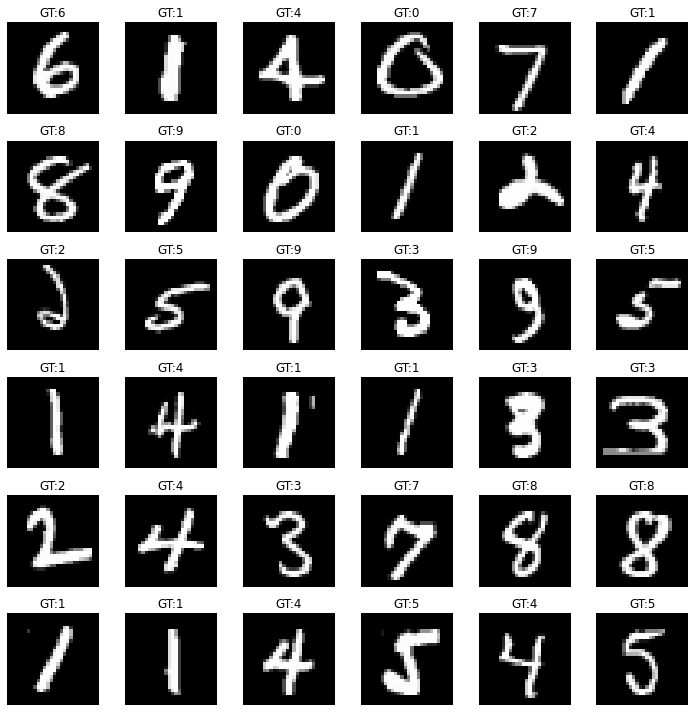

In [9]:
class_list = [0,1,2,3,4,5,6,7,8,9]
plotter.plot_data_grid(train_loader, mean= (0.1307,), std= (0.3081,), class_list=class_list, ncol=6,nrow=6)

# Model

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            # 28x28x1 -> 26x26x4
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=8),
            nn.Dropout(0.05),
            # 26x26x4 -> 24x24x8
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=8),
            nn.Dropout(0.05),
            # 24x24x8 -> 12x12x8
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.layer2 =  nn.Sequential(
            # 12x12x8 -> 10x10x16
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout(0.05),
            # 10x10x12 -> 8x8x12
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout(0.05),
            # 8x8x812-> 6x6x12
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout(0.05),
            # 6x6x16 -> 4x4x16
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, bias=False)
        )
        
        # 4x4x16 -> 1x1x16
        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1),
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=1)

        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.gap(x)
        x = self.classifier(x)
        x = x.view(-1,10)

        return F.log_softmax(x, dim=1)

In [11]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]             864
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
          Dropout-13           [-1, 12, 10, 10]               0
           Conv2d-14             [-1, 1

# Training

In [12]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
trainer = train.Train(model, device, train_loader, optimizer)
tester = test.Test(model, device, test_loader)

for epoch in range(1, 15):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = trainer()
    test_loss, test_acc = tester()
    
    print('TRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


loss=0.07721536606550217 batch_id=937: 100%|██████████| 938/938 [00:14<00:00, 62.61it/s]


TRAIN set: Average loss: 0.2608, Train Accuracy: 91.68%
TEST set: Average loss: 0.0572, Test Accuracy: 98.29%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
TRAIN set: Average loss: 0.0604, Train Accuracy: 98.17%
TEST set: Average loss: 0.0386, Test Accuracy: 98.80%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3
TRAIN set: Average loss: 0.0471, Train Accuracy: 98.51%
TEST set: Average loss: 0.0416, Test Accuracy: 98.60%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
TRAIN set: Average loss: 0.0402, Train Accuracy: 98.69%
TEST set: Average loss: 0.0338, Test Accuracy: 98.73%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5
TRAIN set: Average loss: 0.0378, Train Accuracy: 98.83%
TEST set: Average loss: 0.0277, Test Accuracy: 99.13%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
TRAIN set: Average loss: 0.0330, Train Accuracy: 98.93%
TEST set: Average loss: 0.0266, Test Accuracy: 99.11%


# Results

In [13]:
print('Train Accuracy:', max(trainer.accuracy))
print('Test Accuracy:', max(tester.accuracy))

Train Accuracy: 99.24666666666667
Test Accuracy: 99.29


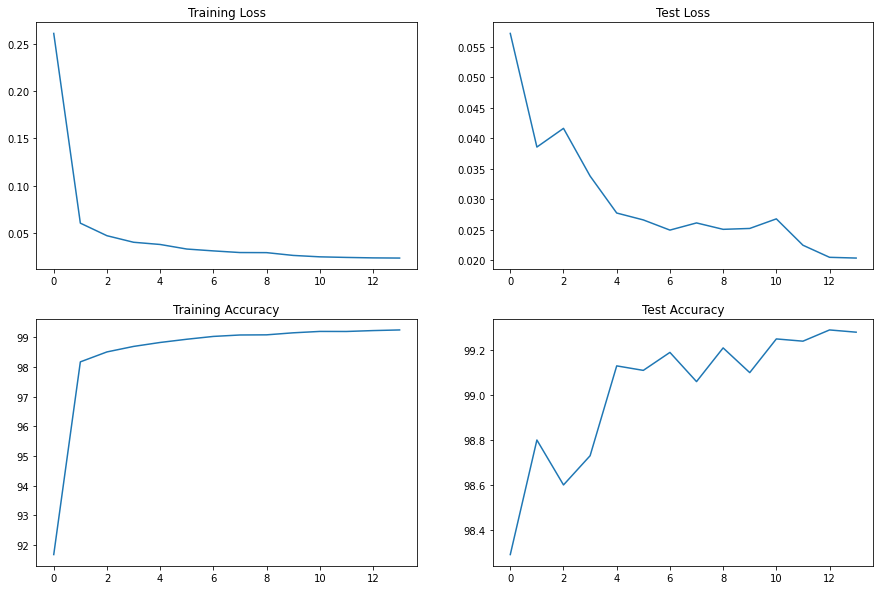

In [14]:
plotter.plot_loss_acc(trainer.loss, trainer.accuracy, tester.loss, tester.accuracy)

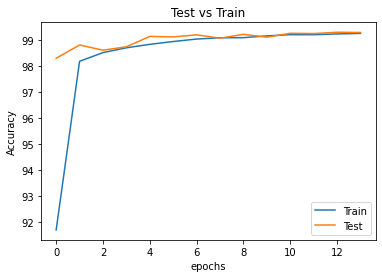

In [15]:
plotter.plot_combined(trainer.accuracy, tester.accuracy,  x_label='epochs', y_label='Accuracy')

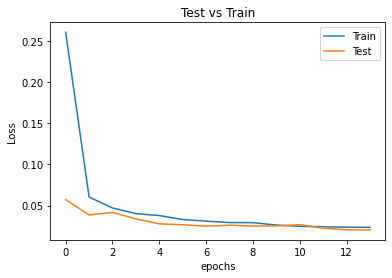

In [16]:
plotter.plot_combined(trainer.loss, tester.loss,  x_label='epochs', y_label='Loss')

In [17]:
class_list = [0,1,2,3,4,5,6,7,8,9]
mean= (0.1307,)
std= (0.3081,)
results = plotter.Results(model, test_loader, device, mean, std, class_list)

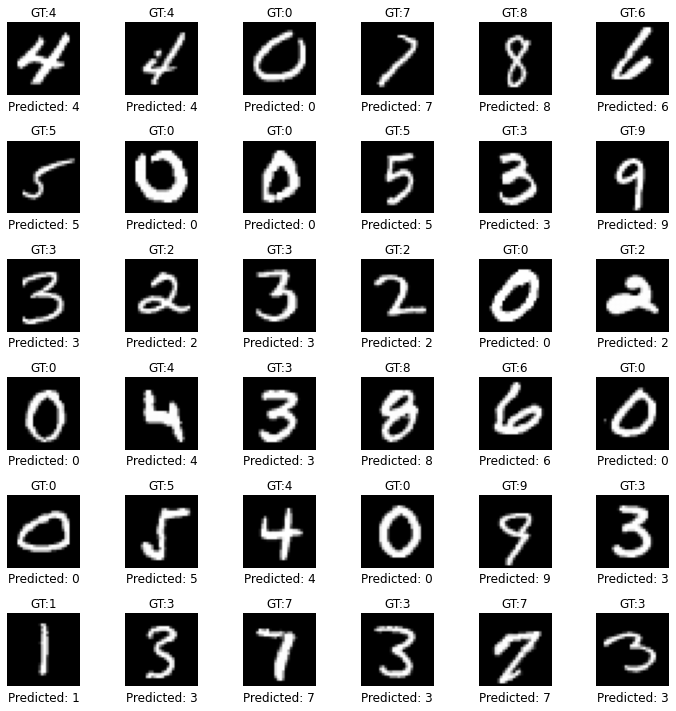

In [18]:
results.plot_batch(6,6)

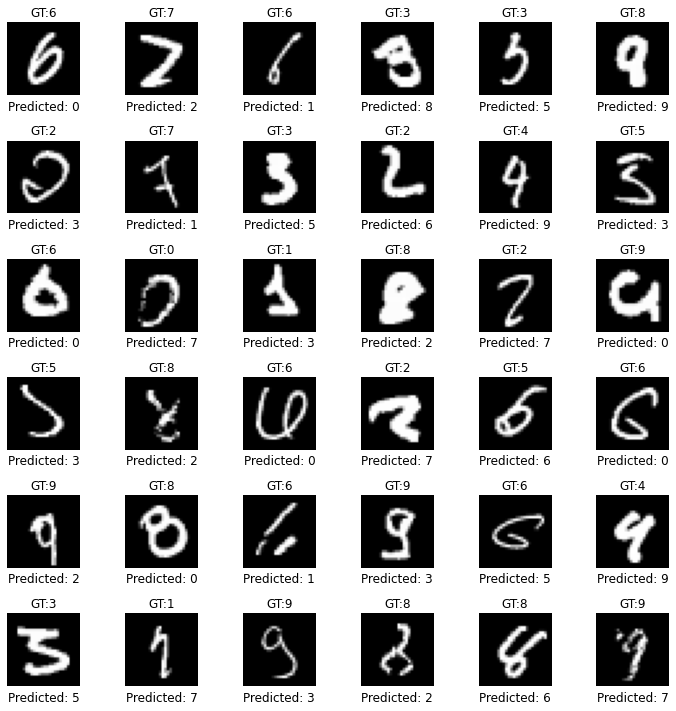

In [19]:
results.plot_incorrect()

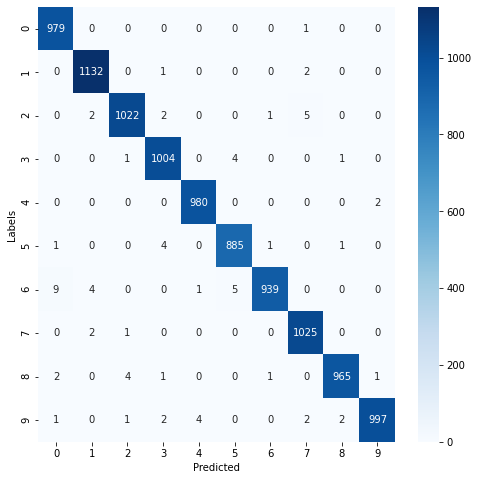

Accuracies of Top 10 Classes in Decreasing Order
Accuracy of class 6 is 98.02
Accuracy of class 9 is 98.81
Accuracy of class 2 is 99.03
Accuracy of class 8 is 99.08
Accuracy of class 5 is 99.22
Accuracy of class 3 is 99.41
Accuracy of class 7 is 99.71
Accuracy of class 1 is 99.74
Accuracy of class 4 is 99.80
Accuracy of class 0 is 99.90


In [20]:
results.class_accuracy()

# Model Architecture

In [ ]:
!pip3 install hiddenlayer

In [ ]:
import hiddenlayer as hl
model = Net().to('cuda')
network_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]).to('cuda'))
network_graph.save("./images/network_1", "png")

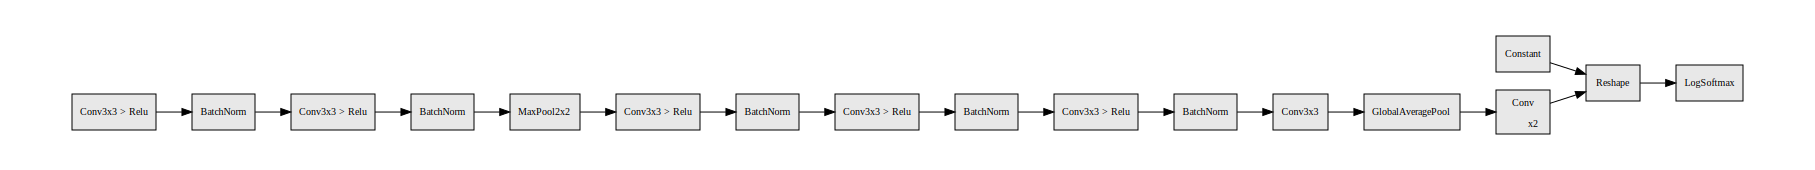

In [23]:
network_graph

# Acheviements

**Total Parameters Used**: 7,826  
**Train Accuracy**: 99.25  
**Test Accuracy**: **99.29**  
**Consistent From**: Consistent at **99.25-99.3**  
**Data Augmentation**: None


## Analysis

We have used DropOut of 5%, which is like dropping 5 out of 100 weights after each layer.

We can observe that, the over-fitting issue has been resolved, as clearly both the Test Loss and Accuracy of the Model are higher than the Training Loss and Accuracy, so which means there is still Learning opportunities and we can puish the training further and get better Test Accuracies.

Also, when observing the Confusion Matrix and the Incorrect Identified Images above, we can see that the Model is confusing between 0 and 6 as there are quite high incorrect prediction of 6 as 0's. Same with 2 and 7.

So, we can now bring some Data Augmentation techniques to Randomly Rotate images while Training, and with some estimation the Rotations look between ±15°.